# Riskfolio-Lib Tutorial:
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 7: Index Tracking/Replicating Portfolios

## 1. Downloading the data:

In [8]:
import numpy as np
import pandas as pd
#import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Data
data = pd.read_excel('data.xlsx',index_col=0).dropna()

# Date range
start = data.index[0]#'2016-01-01'
end = data.index[-1]#'2019-12-30'

# Tickers of assets
assets = ['equity world','bonds','bills','ust bonds 1-3']
assets.sort()

market_index = ['NEIXCTAT Index']

all_assets = assets + market_index
all_assets.sort()

# Downloading data
#data = yf.download(all_assets, start = start, end = end)
#data = data.loc[:,('Adj Close', slice(None))]
data.columns = all_assets

In [9]:
# Calculating returns

Y = data[all_assets].pct_change().dropna()

display(Y.head())

,NEIXCTAT Index,bills,bonds,equity world,ust bonds 1-3
date,,,,,
2000-01-03,-0.2800%,0.1011%,-0.5390%,0.0213%,-0.1299%
2000-01-04,-2.6600%,-3.0831%,0.4339%,0.0372%,0.1366%
2000-01-05,-0.8799%,-1.3588%,-0.4853%,0.0053%,-0.1104%
2000-01-06,-0.9001%,-1.1314%,0.3058%,0.0266%,0.0780%
2000-01-07,-0.9900%,2.3675%,0.2676%,0.0266%,0.0650%


## 2. Estimating Mean Variance Portfolios with Turnover Constraints

### 2.1 Calculating the portfolio that maximizes Sharpe ratio.

In [10]:
import riskfolio as rp

# Building the portfolio object

port = rp.Portfolio(returns=Y[assets])
# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Create Turnover Constraints

port.allowTO = True # Allows to use Turnover Constraints
port.turnover = 0.05 # Maximum deviation in absolute value respect to benchmark weights
# By default benchweights is the equally weighted portfolio,
# if you want to use a different benchmark weights, you must
# specify a weights dataframe with assets names in columns
#port.benchweights = weights # Use a dataframe

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,bills,bonds,equity world,ust bonds 1-3
weights,20.0000%,30.0000%,20.0000%,30.0000%


### 2.2 Plotting portfolio composition

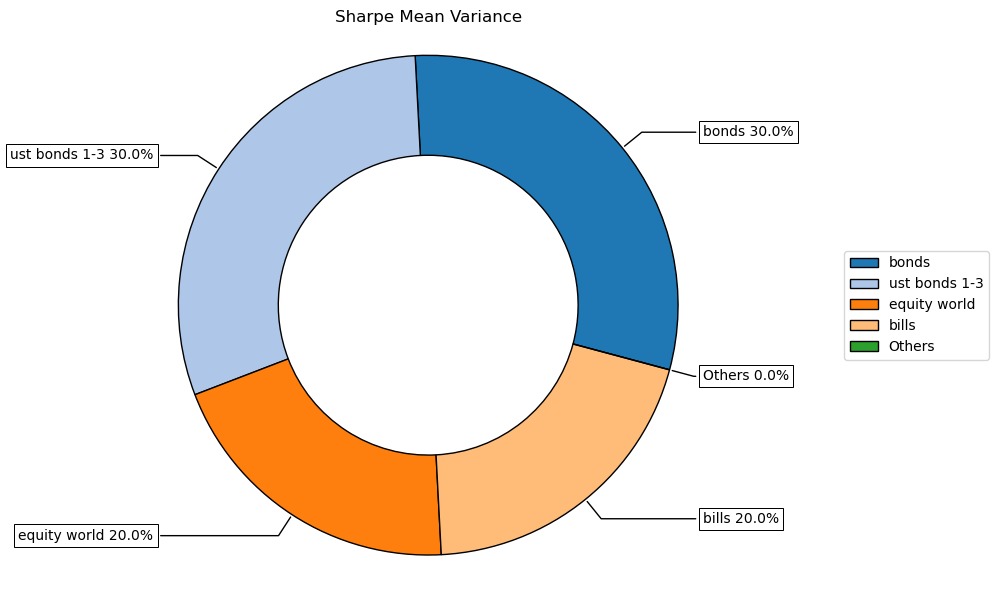

In [11]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                  height=6, width=10, ax=None)

### 2.3 Calculate efficient frontier

In [12]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,bills,bonds,equity world,ust bonds 1-3
0,20.0000%,20.0000%,30.0000%,30.0000%
1,20.0000%,27.6930%,22.3070%,30.0000%
2,20.1343%,30.0000%,20.0000%,29.8657%
3,20.3517%,30.0000%,20.0000%,29.6483%
4,20.5686%,30.0000%,20.0000%,29.4314%


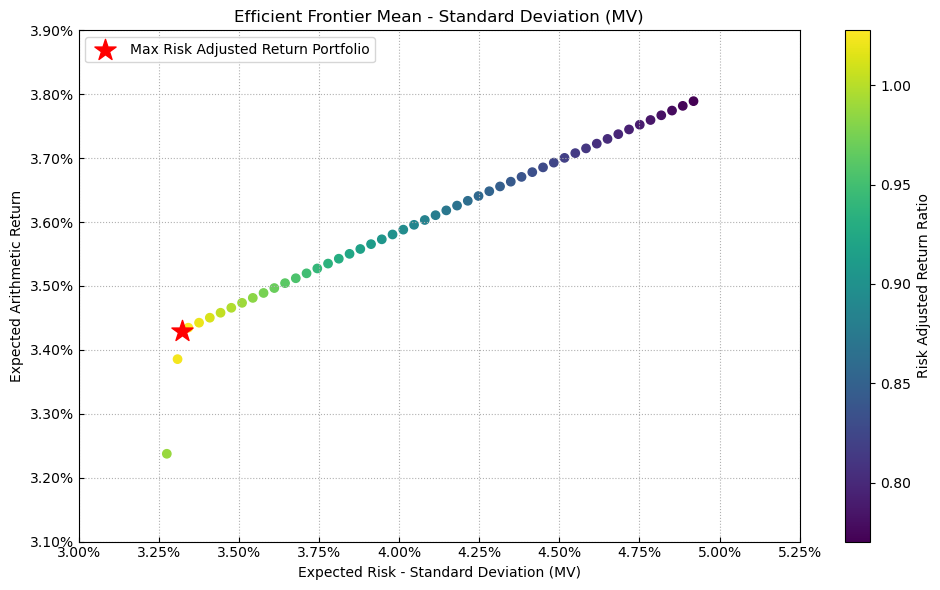

In [13]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

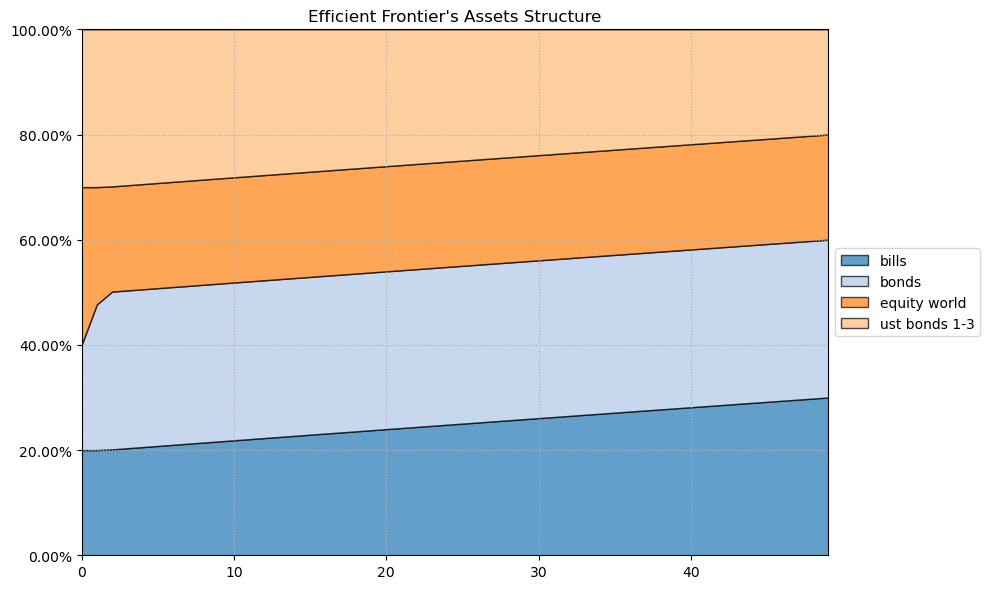

In [14]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Mean Variance Portfolios with Tracking Error Constraints

### 3.1 Calculating the portfolio that maximizes Sharpe ratio.

In [16]:
# Building the portfolio object

port = rp.Portfolio(returns=Y[assets])
# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Create Tracking Error Constraints

port.kindbench = False # True if you have benchmark weights, False if you have an index
port.benchindex = Y[market_index] # Index Returns
port.allowTE = True # Allows to use Tracking Error Constraints
port.TE = 0.008 # Maximum Tracking Error respect to benchmark returns

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = "Sharpe" # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

The problem doesn't have a solution with actual input parameters


AttributeError: 'NoneType' object has no attribute 'T'

### 3.2 Plotting portfolio composition

In [17]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

ValueError: w must be a DataFrame

### 3.3 Calculate efficient frontier

In [18]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

The problem doesn't have a solution with actual input parameters
The problem doesn't have a solution with actual input parameters


NameError: The limits of the frontier can't be found

In [ ]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 3. Estimating Mean Risk Portfolios with Tracking Error Constraints

In this part I will calculate optimal portfolios for several risk measures using a __Tracking Error Constraint respect to an Index__. First I'm going to calculate the portfolio that maximizes risk adjusted return when CVaR is the risk measure, then I'm going to calculate the portfolios that maximize the risk adjusted return for all available risk measures.

### 3.1 Calculating the portfolio that maximizes Return/CVaR ratio.

In [19]:
rm = 'CVaR' # Risk measure

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

The problem doesn't have a solution with actual input parameters


AttributeError: 'NoneType' object has no attribute 'T'

### 3.2 Plotting portfolio composition

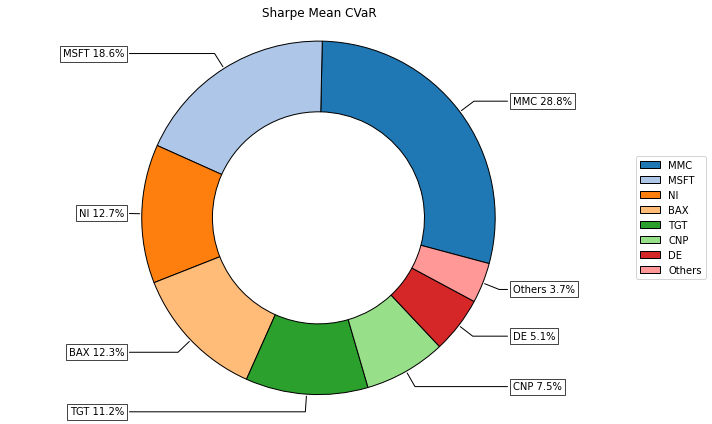

In [14]:
ax = rp.plot_pie(w=w, title='Sharpe Mean CVaR', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3 Calculate efficient frontier

In [15]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
0,0.0000%,0.0000%,2.0452%,7.0613%,0.2202%,2.1294%,8.0718%,0.0000%,0.0000%,3.8039%,...,6.9252%,0.0000%,21.0644%,0.0000%,2.6449%,4.1219%,0.0000%,0.0000%,20.7632%,0.0000%
1,0.0000%,0.0000%,4.2009%,5.7764%,0.0000%,5.9137%,5.4081%,0.0000%,0.0000%,1.7603%,...,7.7028%,0.0000%,14.8608%,0.0000%,0.9315%,7.3066%,0.0000%,0.0000%,19.9813%,0.0000%
2,0.0000%,0.0000%,5.8797%,4.1163%,0.0000%,10.6361%,1.1864%,0.0000%,0.0000%,3.0991%,...,7.5622%,0.0000%,11.6416%,0.0000%,0.0000%,6.7961%,0.0000%,0.0000%,19.1277%,0.0000%
3,0.0000%,0.0000%,6.8007%,0.7004%,0.0000%,12.6094%,0.0000%,0.1934%,0.0000%,0.3745%,...,7.1783%,0.0000%,11.1690%,0.0000%,0.0000%,8.1508%,0.0000%,0.0000%,17.7066%,0.0000%
4,0.0000%,0.0000%,7.3933%,0.0000%,0.0000%,11.4319%,0.0000%,0.0101%,0.0000%,0.0000%,...,9.5695%,0.0000%,6.4963%,0.0000%,0.0000%,10.1450%,0.0000%,0.0000%,15.5312%,0.0000%


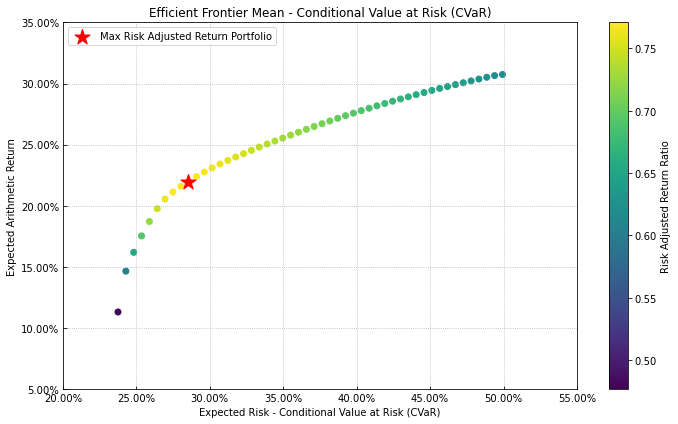

In [16]:
label = 'Max Risk Adjusted Return Portfolio' # Title of point

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

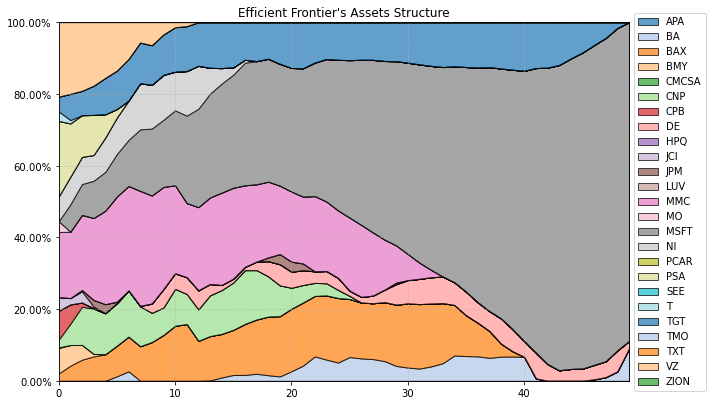

In [17]:
# Plotting efficient frontier composition

ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures

In [18]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [19]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BA,6.16%,7.58%,4.38%,6.30%,3.98%,0.00%,5.74%,0.00%,1.20%,6.88%,2.82%,6.34%,0.00%
BAX,11.50%,9.44%,10.37%,8.96%,10.62%,12.35%,6.52%,0.00%,0.00%,4.71%,0.00%,4.34%,3.58%
BMY,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CMCSA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.98%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CNP,8.48%,7.25%,9.15%,6.00%,9.38%,7.49%,6.83%,28.96%,56.01%,13.71%,32.93%,18.16%,14.74%
CPB,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.41%,5.37%,0.00%,0.00%,0.00%,0.00%,0.00%
DE,3.82%,2.72%,1.18%,2.32%,0.90%,5.14%,5.61%,0.00%,13.08%,1.55%,0.82%,1.01%,8.06%
HPQ,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.34%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
JCI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


<AxesSubplot:>

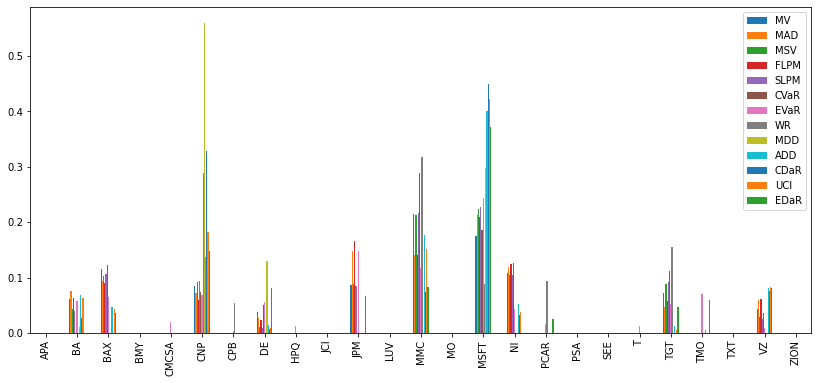

In [20]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)